In [ ]:
mport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gtfparse import read_gtf

# import annotation file

In [ ]:
ann=pd.read_table('genome/dm6_NcbiRefSeq.csv', sep=',')

In [ ]:
ann

,"#""bin""",name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames
0,9,NM_166811.2,chr4,-,1035287,1051378,1037277,1050519,15,"1035287,1037475,1037645,1038358,1043467,104515...","1037422,1037590,1037740,1038437,1043524,104524...",0,CaMKII,cmpl,cmpl,"2,1,2,1,1,1,0,0,1,2,1,1,2,0,-1,"
1,9,NM_001169361.2,chr4,-,1035287,1051378,1037277,1050519,17,"1035287,1037475,1037645,1038358,1040012,104346...","1037422,1037590,1037740,1038434,1040078,104352...",0,CaMKII,cmpl,cmpl,"2,1,2,1,1,1,1,0,0,1,2,1,1,2,0,-1,-1,"
2,9,NM_166810.5,chr4,-,1035287,1051378,1037277,1050519,14,"1035287,1037475,1037645,1038358,1045155,104726...","1037422,1037590,1037740,1038437,1045248,104739...",0,CaMKII,cmpl,cmpl,"2,1,2,1,1,0,0,1,2,1,1,2,0,-1,"
3,9,NM_166812.3,chr4,-,1035287,1053703,1037277,1050519,16,"1035287,1037475,1037645,1038358,1040012,104346...","1037422,1037590,1037740,1038434,1040078,104352...",0,CaMKII,cmpl,cmpl,"2,1,2,1,1,1,1,0,0,1,2,1,1,2,0,-1,"
4,9,NM_001014696.2,chr4,-,1035287,1053703,1037277,1050519,15,"1035287,1037475,1037645,1038358,1043467,104515...","1037422,1037590,1037740,1038458,1043524,104524...",0,CaMKII,cmpl,cmpl,"2,1,2,1,1,1,0,0,1,2,1,1,2,0,-1,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34458,585,NR_026612.1,chrY_DS484142v1_random,-,1550,2815,2815,2815,1,"1550,","2815,",0,Su(Ste):CR42418,none,none,"-1,"
34459,585,NR_026627.1,chrY_DS484909v1_random,-,0,1356,1356,1356,1,"0,","1356,",0,Su(Ste):CR42433,none,none,"-1,"
34460,585,NM_001110696.2,chrY_DS485423v1_random,-,561,879,561,879,2,"561,868,","814,879,",0,CG40635,cmpl,cmpl,"2,0,"
34461,585,NR_026633.1,chrY_DS485523v1_random,-,13,1118,1118,1118,1,"13,","1118,",0,Su(Ste):CR42439,none,none,"-1,"


In [ ]:
# delete all gene that have no cds, or cds that is unkown or incomplete
# no need to redo it with cdsEndStat column, they have the same value each time
ann = ann[~ ann['cdsStartStat'].str.contains('none') & 
          ~ ann['cdsStartStat'].str.contains('unk') & 
          ~ ann['cdsStartStat'].str.contains('incmpl')]

In [ ]:
ann = ann[ann.exonFrames != -1]
ann = ann[abs(ann.cdsStart - ann.cdsEnd) > 1]

In [ ]:
def parse_annotation(ann):
    '''
    This function will keep the longest transcript for each gene
    '''
    gene_list=[] 
    dic={}

    for name in ann['name2']:
        tx=0
        longest_transcript=0
        gene_list.append(name)
        tmp = ann.loc[ann['name2']== name] #tmp will have all rows for the same gene (it's faster than going row by row)
        for index,row in tmp.iterrows():
            exon_starts = str.split(row['exonStarts'], ",") # list of starts
            exon_ends = str.split(row['exonEnds'], ",") # list of end
            exon_starts = [float(start) for start in exon_starts if start.strip() != ''] #convert list element into floats if not empty
            exon_ends = [float(end) for end in exon_ends if end.strip() != '']
            for start, end in zip(exon_starts, exon_ends):
                start+=1 # converting from 0 to 1-based
                tx += abs(start - end) # add exons length
            if tx > longest_transcript : #after calculating exons length, if it's bigger than the latest longest_transcript recorded, replace it
                longest_transcript = tx

            #after fiding the longest_transcript, create dictionary with its coordinates
            dic[row['name2']] = {'strand': row['strand'], 'chrom':  row['chrom'], 'exons_sum':longest_transcript,
                                 'txStart' : row['txStart']+1, 'txEnd' : row['txEnd'],
                                 'cdsStart' : row['cdsStart']+1, 'cdsEnd' : row['cdsEnd'],
                                 'exon_starts' : [int(x) + 1 for x in str.split(row['exonStarts'], ",") if x != '' ], 'exon_ends' : str.split(row['exonEnds'], ",") }

    return dic

In [ ]:
annotation_dictionary=parse_annotation(ann)

In [ ]:
#convert the dictionary to dataframe
annotation_df=pd.DataFrame(annotation_dictionary).T

In [ ]:
annotation_df.index.name = 'gene_name'
annotation_df.reset_index(inplace=True)
annotation_df

,gene_name,strand,chrom,exons_sum,txStart,txEnd,cdsStart,cdsEnd,exon_starts,exon_ends
0,CaMKII,-,chr4,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ..."
1,RhoGAP102A,+,chr4,17330.0,254997,265574,255517,264958,"[254997, 258312, 258528, 259278, 259447, 26123...","[257404, 258466, 258672, 259370, 259604, 26151..."
2,dati,-,chr4,16501.0,375640,388322,375963,387858,"[375640, 377094, 377758, 377885, 378396, 37871...","[376631, 377669, 377825, 378202, 378561, 37890..."
3,zfh2,+,chr4,32414.0,501810,540874,521504,538554,"[501810, 503851, 515582, 521473, 524331, 52490...","[501857, 504138, 515631, 523104, 524512, 52652..."
4,gw,-,chr4,24887.0,649971,660608,650257,658337,"[649971, 652305, 652646, 652901, 653870, 65450...","[651030, 652584, 652842, 653051, 654048, 65479..."
...,...,...,...,...,...,...,...,...,...,...
13962,Gpa2,-,chrUn_CP007081v1,405.0,3093,3557,3093,3540,"[3093, 3244]","[3185, 3557, ]"
13963,klhl10,+,chrUn_CP007081v1,5473.0,56702,85431,56945,85209,"[56702, 56891, 57320, 57659, 83719, 83902]","[56827, 57267, 57604, 57923, 83841, 85431, ]"
13964,CG41561,-,chrUn_DS483646v1,1424.0,7386,9527,7445,9478,"[7386, 7582, 9154, 9435]","[7523, 8551, 9380, 9527, ]"
13965,SteXh:CG42398,+,chrX_DS483995v1_random,612.0,1449,2180,1479,2114,"[1449, 1547, 2108]","[1489, 2047, 2180, ]"


In [ ]:
# delete genes in weird chromosomes that start with a certain pattern
annotation_df = annotation_df[~ annotation_df['chrom'].str.contains(r'chrY_(.+)') &
                              ~ annotation_df['chrom'].str.contains(r'chrUn_(.+)') & 
                              ~ annotation_df['chrom'].str.contains(r'chrX_(.+)')]

/tmp/ipykernel_89644/1154674936.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  annotation_df = annotation_df[~ annotation_df['chrom'].str.contains(r'chrY_(.+)') &
/tmp/ipykernel_89644/1154674936.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~ annotation_df['chrom'].str.contains(r'chrUn_(.+)') &
/tmp/ipykernel_89644/1154674936.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~ annotation_df['chrom'].str.contains(r'chrX_(.+)')]


In [ ]:
annotation_df

,gene_name,strand,chrom,exons_sum,txStart,txEnd,cdsStart,cdsEnd,exon_starts,exon_ends
0,CaMKII,-,chr4,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ..."
1,RhoGAP102A,+,chr4,17330.0,254997,265574,255517,264958,"[254997, 258312, 258528, 259278, 259447, 26123...","[257404, 258466, 258672, 259370, 259604, 26151..."
2,dati,-,chr4,16501.0,375640,388322,375963,387858,"[375640, 377094, 377758, 377885, 378396, 37871...","[376631, 377669, 377825, 378202, 378561, 37890..."
3,zfh2,+,chr4,32414.0,501810,540874,521504,538554,"[501810, 503851, 515582, 521473, 524331, 52490...","[501857, 504138, 515631, 523104, 524512, 52652..."
4,gw,-,chr4,24887.0,649971,660608,650257,658337,"[649971, 652305, 652646, 652901, 653870, 65450...","[651030, 652584, 652842, 653051, 654048, 65479..."
...,...,...,...,...,...,...,...,...,...,...
13957,CG2003,+,chr3R,5355.0,31986849,31990909,31989299,31989742,"[31986849, 31989252, 31989387, 31989591]","[31987127, 31989329, 31989530, 31990909, ]"
13958,CG2053,+,chr3R,2601.0,32038330,32039753,32038483,32039429,"[32038330, 32039398]","[32039347, 32039753, ]"
13959,krz,-,chr3R,7265.0,32048607,32051993,32049028,32051839,"[32048607, 32051269]","[32049869, 32051993, ]"
13960,mod,+,chr3R,4231.0,32052620,32054974,32052735,32054764,"[32052620, 32053246, 32053623, 32054424]","[32052977, 32053555, 32054357, 32054974, ]"


In [ ]:
def mRNA_positions(df):
    '''
    This function will convert cds genomic coordinates to mRNA coordinates and calculate mRNA length/end
    '''
    #count will keep count nucleotides
    count=0
    #mRNA dictionary that have 2 keys for each gene : tx_position (genomic) and mRNA position so we can get for each mRNA position its corresponding position
    mRNA={} 
    tmp=[]
    #initialize columns
    df['cds_mRNA_start']=''
    df['cds_mRNA_end']=''
    df['mRNA_end']=''

    for cdsStart, cdsEnd, gene, starts, ends, strand in zip(df['cdsStart'], df['cdsEnd'], df['gene_name'], df['exon_starts'], df['exon_ends'], df['strand']):
        mRNA[gene] = {'strand' : strand, 'tx_position' : [], 'mRNA_position' : []}
        for start, end in zip(starts,ends):
            if start != '' and end != '':             
                for nucleotide in range(int(start),int(end) + 1):
                    tmp.append(nucleotide)
                    count += 1 #adds 1 after adding the first nucleotide
                    mRNA[gene]['tx_position'].append((nucleotide)) #adds the nucleotide genomic position
                    mRNA[gene]['mRNA_position'].append((count)) #adds the nucleotide mRNA position
                    if int(cdsStart) == int(nucleotide): #when the nucleotide position is the start of cds, record its mRNA position in another column
                        df.loc[df['gene_name'] == gene, 'cds_mRNA_start']=count
                    if int(cdsEnd) == int(nucleotide):
                        df.loc[df['gene_name'] == gene, 'cds_mRNA_end']=count
        #when finishing for a given gene, mRNA_end (=mRNA_length since mRNA always starts with 1), will be stored in another column 
        df.loc[df['gene_name'] == gene, 'mRNA_end']=count
        count=0 #going to start another gene        
        tmp=[] #going to start another gene 
    return df, mRNA

In [ ]:
annotation_df_mRNA, mRNA_dictionary = mRNA_positions(annotation_df)

/tmp/ipykernel_89644/2356781784.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cds_mRNA_start']=''
/tmp/ipykernel_89644/2356781784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cds_mRNA_end']=''
/tmp/ipykernel_89644/2356781784.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
annotation_df_mRNA

,gene_name,strand,chrom,exons_sum,txStart,txEnd,cdsStart,cdsEnd,exon_starts,exon_ends,cds_mRNA_start,cds_mRNA_end,mRNA_end
0,CaMKII,-,chr4,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845
1,RhoGAP102A,+,chr4,17330.0,254997,265574,255517,264958,"[254997, 258312, 258528, 259278, 259447, 26123...","[257404, 258466, 258672, 259370, 259604, 26151...",521,4291,4907
2,dati,-,chr4,16501.0,375640,388322,375963,387858,"[375640, 377094, 377758, 377885, 378396, 37871...","[376631, 377669, 377825, 378202, 378561, 37890...",324,2699,3163
3,zfh2,+,chr4,32414.0,501810,540874,521504,538554,"[501810, 503851, 515582, 521473, 524331, 52490...","[501857, 504138, 515631, 523104, 524512, 52652...",418,9429,11695
4,gw,-,chr4,24887.0,649971,660608,650257,658337,"[649971, 652305, 652646, 652901, 653870, 65450...","[651030, 652584, 652842, 653051, 654048, 65479...",287,4441,4792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13957,CG2003,+,chr3R,5355.0,31986849,31990909,31989299,31989742,"[31986849, 31989252, 31989387, 31989591]","[31987127, 31989329, 31989530, 31990909, ]",327,653,1820
13958,CG2053,+,chr3R,2601.0,32038330,32039753,32038483,32039429,"[32038330, 32039398]","[32039347, 32039753, ]",154,1050,1374
13959,krz,-,chr3R,7265.0,32048607,32051993,32049028,32051839,"[32048607, 32051269]","[32049869, 32051993, ]",422,1834,1988
13960,mod,+,chr3R,4231.0,32052620,32054974,32052735,32054764,"[32052620, 32053246, 32053623, 32054424]","[32052977, 32053555, 32054357, 32054974, ]",116,1744,1954


In [ ]:
def reverse_mRNA(mRNA):
    '''
    This function reverse mRNA counts if strand is '-'
    
    strand + : 1 2 3 4 5 6 7 8 9 10
    strand - : 10 9 8 7 6 5 4 3 2 1 
    '''
    for gene in mRNA.keys():
        if mRNA[gene]['strand'] == '-':
            mRNA[gene]['mRNA_position'].reverse()
            mRNA[gene]['tx_position'].reverse()

In [ ]:
reverse_mRNA(mRNA_dictionary)

# PEAKS

In [ ]:
#import peaks
peaks=pd.read_table('Analysis/clip-seq/G080/icount_output/group/group_scores_unique.tsv')

In [ ]:
peaks = peaks[peaks['FDR']<0.05]
peaks

,chrom,position,strand,name,group_id,score,score_extended,FDR
997,2L,10282,-,l(2)gl,FBgn0002121,2,4,0.00603
998,2L,10283,-,l(2)gl,FBgn0002121,1,4,0.00603
999,2L,10285,-,l(2)gl,FBgn0002121,1,5,0.00000
1007,2L,10368,-,l(2)gl,FBgn0002121,5,7,0.00000
1008,2L,10369,-,l(2)gl,FBgn0002121,1,7,0.00000
...,...,...,...,...,...,...,...,...
1022251,rDNA,71848,+,pre-rRNA:CR45847,FBgn0267507,75,335,0.00000
1022252,rDNA,71849,+,28SrRNA:CR45844,FBgn0267504,65,304,0.00000
1022253,rDNA,71849,+,pre-rRNA:CR45847,FBgn0267507,65,304,0.00000
1022254,rDNA,71850,+,28SrRNA:CR45844,FBgn0267504,3,204,0.00000


In [ ]:
#keep only genes that have at least 20 peaksvv
peaks = peaks[peaks['group_id'].isin(counts.index[counts >= 20])]

# MERGE

In [ ]:
# Merge the dataframes based on the position 
result = pd.merge(annotation_df_mRNA, peaks, how='inner', left_on=['gene_name'],
                     right_on=['name'])

In [ ]:
result = result.drop(['strand_y', 'name', 'chrom_x'], axis=1)
result.rename(columns={'strand_x': 'strand', 'chrom_y': 'chrom'}, inplace=True)

# convert peaks genomic positions to mRNA positions

In [ ]:
def find_mRNA_position(dictionary, gene_name, tx_position_value):
    if gene_name in dictionary and 'mRNA_position' in dictionary[gene_name]:
        tx_positions = dictionary[gene_name]['tx_position']
        mRNA_positions = dictionary[gene_name]['mRNA_position']
        if tx_position_value in tx_positions:
            tx_index = list(tx_positions).index(tx_position_value)
            mRNA_list = list(mRNA_positions)
            if tx_index <= len(mRNA_list):
                return mRNA_list[tx_index]
            else:
                return('NaN')
        else :
            return('NaN')
    else:
        return('NaN')

In [ ]:
peaks_mRNA_pos=[]
for gene, position in zip(result['gene_name'], result['position']):
    peaks_mRNA_pos.append(find_mRNA_position(mRNA_dictionary, gene, int(position)))

In [ ]:
result['peak_mRNA'] = peaks_mRNA_pos

In [ ]:
result

,gene_name,strand,exons_sum,txStart,txEnd,cdsStart,cdsEnd,exon_starts,exon_ends,cds_mRNA_start,cds_mRNA_end,mRNA_end,chrom,position,group_id,score,score_extended,FDR,peak_mRNA
0,CaMKII,-,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845,4,1035287,FBgn0264607,3,8,0.001795,NaN
1,CaMKII,-,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845,4,1035288,FBgn0264607,1,8,0.001795,NaN
2,CaMKII,-,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845,4,1035289,FBgn0264607,1,8,0.001795,NaN
3,CaMKII,-,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845,4,1035290,FBgn0264607,3,8,0.001795,NaN
4,CaMKII,-,41811.0,1037155,1051378,1037278,1050519,"[1037155, 1037476, 1037646, 1038359, 1040013, ...","[1037422, 1037590, 1037740, 1038437, 1040078, ...",124,1719,1845,4,1035316,FBgn0264607,4,7,0.004985,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296515,Map205,-,14786.0,32057016,32068441,32057322,32067996,"[32057016, 32066329]","[32059145, 32068441, ]",307,3798,4243,3R,32057326,FBgn0002645,1,6,0.002414,311
296516,Map205,-,14786.0,32057016,32068441,32057322,32067996,"[32057016, 32066329]","[32059145, 32068441, ]",307,3798,4243,3R,32057327,FBgn0002645,1,4,0.026811,312
296517,Map205,-,14786.0,32057016,32068441,32057322,32067996,"[32057016, 32066329]","[32059145, 32068441, ]",307,3798,4243,3R,32057847,FBgn0002645,1,5,0.005649,832
296518,Map205,-,14786.0,32057016,32068441,32057322,32067996,"[32057016, 32066329]","[32059145, 32068441, ]",307,3798,4243,3R,32057849,FBgn0002645,3,5,0.005649,834


# calculating UTRs 

In [ ]:
# get indexes of the line where strand == '-'
idx = (result['strand'] == '-')

In [ ]:
# switch column values of those genes in strand '-'
result.loc[idx,['cds_mRNA_start','cds_mRNA_end']] = result.loc[idx,['cds_mRNA_end','cds_mRNA_start']].values

In [ ]:
result[['gene_name', 'strand', 'chrom','cdsStart', 'cdsEnd','cds_mRNA_start','cds_mRNA_end', 'mRNA_end']]

,gene_name,strand,chrom,cdsStart,cdsEnd,cds_mRNA_start,cds_mRNA_end,mRNA_end
0,CaMKII,-,4,1037278,1050519,1719,124,1845
1,CaMKII,-,4,1037278,1050519,1719,124,1845
2,CaMKII,-,4,1037278,1050519,1719,124,1845
3,CaMKII,-,4,1037278,1050519,1719,124,1845
4,CaMKII,-,4,1037278,1050519,1719,124,1845
...,...,...,...,...,...,...,...,...
296515,Map205,-,3R,32057322,32067996,3798,307,4243
296516,Map205,-,3R,32057322,32067996,3798,307,4243
296517,Map205,-,3R,32057322,32067996,3798,307,4243
296518,Map205,-,3R,32057322,32067996,3798,307,4243


In [ ]:
result['5utr_start'] = result.apply(lambda row: row['mRNA_end'] if row['strand'] == '-' else 1, axis=1)
result['5utr_end'] = result.apply(lambda row: row['cds_mRNA_start']+1 if row['strand'] == '-' else  row['cds_mRNA_start']-1 , axis=1)
result['3utr_start'] = result.apply(lambda row: row['cds_mRNA_end']-1 if row['strand'] == '-' else  row['cds_mRNA_end']+1, axis=1)
result['3utr_end'] = result.apply(lambda row: 1 if row['strand'] == '-' else row['mRNA_end'], axis=1)

In [ ]:
# Replace 'NaN' strings with actual NaN values
result.replace('NaN', np.nan, inplace=True)

In [ ]:
result.dropna(subset=['cds_mRNA_start', 'cds_mRNA_end', '5utr_start', '5utr_end', '3utr_start', '3utr_end', 'peak_mRNA'], how='any', inplace=True)

# new Dataframe format

In [ ]:
def determine_region(row):
    number = row['peak_mRNA']  # Replace with the column containing the number you want to check
    if number != 'NaN' :
        if int(row['3utr_start']) <= int(number) <= int(row['3utr_end']):
            return '3UTR'
        elif int(row['5utr_start']) <= int(number) <= int(row['5utr_end']):
            return '5UTR'
        elif int(row['cds_mRNA_start']) <= int(number) <= int(row['cds_mRNA_end']):
            return 'CDS'
        else:
            return 'None'
    else:
        pass

In [ ]:
result['region'] = result.apply(determine_region, axis=1)

In [ ]:
def new_format(df):
    '''
    This function will create new DataFrame in the desired format
    '''

    new_data = []

    for _, row in df.iterrows():
        gene_id = row['gene_name']
        regions = ['5utr', 'cds_mRNA', '3utr']
        peak_mRNA = row['peak_mRNA']
        strand = row['strand']
        score= row['score']

        for region in regions:
            region_start = row[f"{region}_start"]
            region_end = row[f"{region}_end"]
            new_data.append([gene_id, strand, region, region_start, region_end, peak_mRNA, score])
    return new_data


new_result = pd.DataFrame(new_format(result), columns=['gene_name', 'strand', 'region','start','end', 'peak_mRNA', 'score'])

In [ ]:
new_result

,gene_name,strand,region,start,end,peak_mRNA,score
0,CaMKII,-,5utr,1845,1720,7.0,1
1,CaMKII,-,cds_mRNA,1719,124,7.0,1
2,CaMKII,-,3utr,123,1,7.0,1
3,CaMKII,-,5utr,1845,1720,8.0,2
4,CaMKII,-,cds_mRNA,1719,124,8.0,2
...,...,...,...,...,...,...,...
556399,Map205,-,cds_mRNA,3798,307,834.0,3
556400,Map205,-,3utr,306,1,834.0,3
556401,Map205,-,5utr,4243,3799,836.0,1
556402,Map205,-,cds_mRNA,3798,307,836.0,1


In [ ]:
# Filter rows based on peak_mRNA being within the range [start, end] or greater/lesser than start/end
filtered_new_result = new_result[new_result.apply(lambda row: (row['start'] <= int(row['peak_mRNA']) <= row['end']) or
                                                            (int(row['peak_mRNA']) >= int(row['end'])) and  (int(row['peak_mRNA']) <= row['start'])
                                                  if pd.notna(row['peak_mRNA']) else False, axis=1)]

In [ ]:
filtered_new_result

,gene_name,strand,region,start,end,peak_mRNA,score
2,CaMKII,-,3utr,123,1,7.0,1
5,CaMKII,-,3utr,123,1,8.0,2
8,CaMKII,-,3utr,123,1,9.0,2
11,CaMKII,-,3utr,123,1,59.0,1
14,CaMKII,-,3utr,123,1,60.0,1
...,...,...,...,...,...,...,...
556390,Map205,-,cds_mRNA,3798,307,311.0,1
556393,Map205,-,cds_mRNA,3798,307,312.0,1
556396,Map205,-,cds_mRNA,3798,307,832.0,1
556399,Map205,-,cds_mRNA,3798,307,834.0,3


# Relative positions in sequence

In [ ]:
def relative_position(row, df):
    # Group by 'group_id' and 'region', then calculate the 'position' column
    relative_position = (row['peak_mRNA'] - row['start']) / (row['end'] - row['start'])

    # Adjust position for negative strand genes
    #if row['strand'] == '-':
     #   relative_position = 1 - abs(relative_position)
    df.loc[row.name, 'relative_position'] = relative_position
    return relative_position

        
#filtered_new_result['relative_position'] =filtered_new_result.apply(relative_position, axis=1)

In [ ]:
for index, row in filtered_new_result.iterrows():
    relative_position(row, filtered_new_result)

/tmp/ipykernel_89644/2694971130.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[row.name, 'relative_position'] = relative_position


In [ ]:
# Define a function to calculate normalized position based on region and strand
def calculate_normalized_position(row, df):
    if row['region'] == '5utr':
        normalized_position = (row['relative_position']) * 19
    elif row['region'] == 'cds_mRNA':
        normalized_position = 20 + (row['relative_position']) * 49
    else:
        normalized_position = 70 + (row['relative_position']) * 29
    df.loc[row.name, 'normalized_position'] = normalized_position
    return normalized_position

In [ ]:
# Calculate normalized position for each row and add the 'normalized_position' column
for index, row in filtered_new_result.iterrows():
    calculate_normalized_position(row, filtered_new_result)

/tmp/ipykernel_89644/253383429.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[row.name, 'normalized_position'] = normalized_position


In [ ]:
filtered_new_result

,gene_name,strand,region,start,end,peak_mRNA,score,relative_position,normalized_position
2,CaMKII,-,3utr,123,1,7.0,1,0.950820,97.573770
5,CaMKII,-,3utr,123,1,8.0,2,0.942623,97.336066
8,CaMKII,-,3utr,123,1,9.0,2,0.934426,97.098361
11,CaMKII,-,3utr,123,1,59.0,1,0.524590,85.213115
14,CaMKII,-,3utr,123,1,60.0,1,0.516393,84.975410
...,...,...,...,...,...,...,...,...,...
556390,Map205,-,cds_mRNA,3798,307,311.0,1,0.998854,68.943856
556393,Map205,-,cds_mRNA,3798,307,312.0,1,0.998568,68.929820
556396,Map205,-,cds_mRNA,3798,307,832.0,1,0.849613,61.631051
556399,Map205,-,cds_mRNA,3798,307,834.0,3,0.849040,61.602979


/tmp/ipykernel_89644/3306627142.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=filtered_new_result, x='normalized_position', color="#00B2EE", fill=True, alpha=0.3, shade=True)


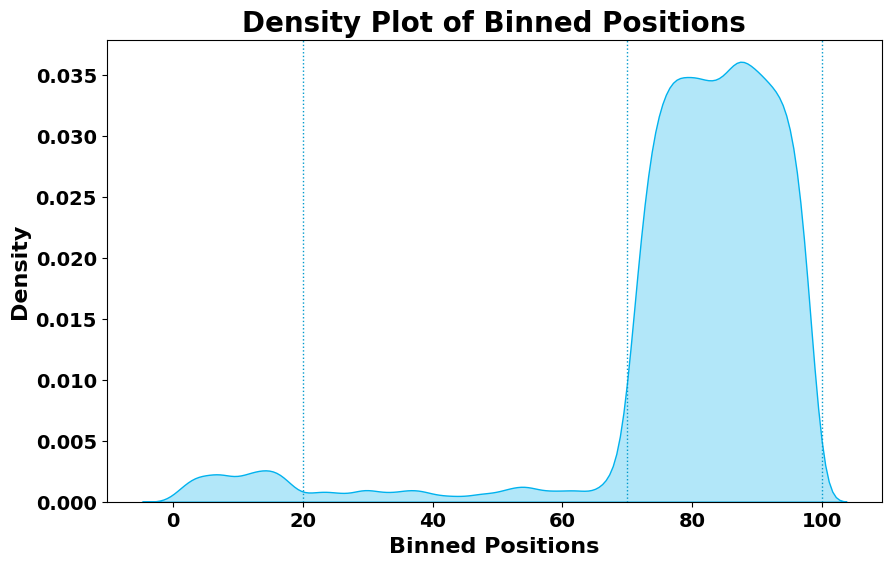

In [ ]:
# Assuming 'df3' is your DataFrame

# Create the plot
plt.figure(figsize=(10, 6))

# Create density continuous line plot
sns.kdeplot(data=filtered_new_result, x='normalized_position', color="#00B2EE", fill=True, alpha=0.3, shade=True)

# Add vertical lines
plt.axvline(x=20, linestyle="dotted", color="#009ACD", linewidth=1)
plt.axvline(x=70, linestyle="dotted", color="#009ACD", linewidth=1)
plt.axvline(x=100, linestyle="dotted", color="#009ACD", linewidth=1)

# Set labels and title
plt.xlabel("Binned Positions", fontsize=16, fontweight="bold")
plt.ylabel("Density", fontsize=16, fontweight="bold")
plt.title("Density Plot of Binned Positions", fontsize=20, fontweight="bold")

# Customize text sizes
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold")

# Show plot
plt.show()